In [1]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

In [12]:
class Direction(Enum):
    RIGHT = (0, 1)
    LEFT = (0, -1)
    UP = (-1, 0)
    DOWN = (1, 0)


class GridWorld:

    def __init__(self):
        self.state_dtype = np.dtype([('key', 'U2'), ('state_value', 'f4')])
        self.grid = np.array([[(None, 0) for _ in range(5)]
                             for _ in range(5)], dtype=self.state_dtype)
        self.grid[0, 1]['key'] = 'A'
        self.grid[0, 3]['key'] = 'B'
        self.grid[4, 1]['key'] = 'A_'
        self.grid[2, 3]['key'] = 'B_'

    def move(self, position, direction: Direction):
        # basically (pos[0]+dir[0], pos[1]+dir[1])
        new_position = tuple(sum(x) for x in zip(position, direction.value))

        if self.grid[position]['key'] == 'A':
            new_position = (4,1)
            return 10, new_position

        elif self.grid[position]['key'] == 'B':
            new_position = (2,3)
            return 5, new_position
        
        if new_position[0] < 0 or new_position[1] < 0 or new_position[0] > 4 or new_position[1] > 4:
            return -1, position
        else:
            return 0, new_position

    def get_state_value_after_move(self, position, direction):
        
        if self.grid[position]['key'] == 'A':
            return self.grid[(4, 1)]['state_value']
        
        if self.grid[position]['key'] == 'B':
            return self.grid[(2, 3)]['state_value']
        
        new_position = tuple(sum(x) for x in zip(position, direction.value))

        if new_position[0] < 0 or new_position[1] < 0 or new_position[0] > 4 or new_position[1] > 4:
            return -np.inf
        
        return self.grid[new_position]['state_value']

    def reset(self):
        self.grid = np.array([[(None, 0) for _ in range(5)] for _ in range(5)], dtype=self.state_dtype)
        self.grid[0, 1]['key'] = 'A'
        self.grid[0, 3]['key'] = 'B'
        self.grid[4, 1]['key'] = 'A_'
        self.grid[2, 3]['key'] = 'B_'

        

In [4]:
class CellPolicy:
    
    def __init__(self, initial_choices):
        self.choices = np.array(initial_choices)

    def update(self, new_choices):
        self.choices = np.array(new_choices) 

    def get_choices(self) -> np.ndarray:
        return self.choices
    
    def __str__(self):
        choices_to_sign_map = [None, '🡢', '🡠', '⮂', '🡡', '🡥', '🡤', '⤧', '🡣', '🡦', '🡧', '⤩', '⮁', '⤨', '⤪', '⬤']
        
        enum_val_map = {
            Direction.RIGHT : 0,
            Direction.LEFT : 1,
            Direction.UP : 2,
            Direction.DOWN : 3
        }

        mapped_directions = np.array([enum_val_map[direction] for direction in self.choices])
        occurences = np.zeros((4,))
        occurences[mapped_directions] = 1

        index = 0
        for i in range(len(occurences)):
            index+=2**i * occurences[i]

        return choices_to_sign_map[int(index)]
    
    def __repr__(self):
        return self.__str__()

In [5]:
def print_policy(policy):
    print('--- POLICY ---')
    #print(np.array([[tup['state_value'] for tup in row] for row in grid_world.grid]))
    for row in policy:
        print('- ' * 12)
        print('|', end='')
        for cell_policy in row:
            print(f' {cell_policy} |', end='')
        
        print()
    print('- ' * 12)
    print('--- END POLICY ---')
    print()

Final Policy:
--- POLICY ---
- - - - - - - - - - - - 
| 🡢 | ⬤ | 🡠 | ⬤ | 🡠 |
- - - - - - - - - - - - 
| 🡡 | 🡡 | 🡡 | 🡡 | 🡠 |
- - - - - - - - - - - - 
| 🡡 | 🡡 | 🡡 | 🡡 | 🡡 |
- - - - - - - - - - - - 
| 🡡 | 🡡 | 🡡 | 🡡 | 🡡 |
- - - - - - - - - - - - 
| 🡡 | 🡡 | 🡡 | 🡡 | 🡡 |
- - - - - - - - - - - - 
--- END POLICY ---



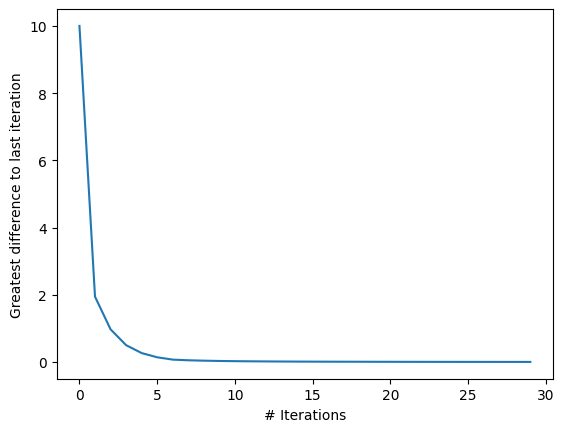

In [15]:
grid_world = GridWorld()
iterations = 15
discount = 0.9
diff_arr = []

policy = np.array([[CellPolicy([Direction.UP, Direction.RIGHT, Direction.DOWN, Direction.LEFT]) for _ in range(5)] for _ in range(5)])

def print_status(iteration):
    print('--- STATUS ---')
    print('Grid:')
    #print(np.array([[tup['state_value'] for tup in row] for row in grid_world.grid]))
    for row in grid_world.grid:
        print('- ' * len(grid_world.grid[0]) * 5)
        print('|', end='')
        for cell in row:
            cell_value = cell['state_value']

            # create equal spacing for printing    
            value_prefix = ' ' if cell_value > 0 else ''
            value_prefix = '' if cell_value >= 10 else value_prefix
            cell_value = round(cell_value, 4)
            print(f' {value_prefix}{cell_value:.4f} |', end='')
        
        print()
    print('- ' * len(grid_world.grid[0]) * 5)
    print('Greatest value change compared to last iteration:')
    print(diff_arr[iteration])
    print('--- END STATUS ---')
    print()

iterations_to_print = [0, 1, 5, iterations - 1]
diff = np.inf
changed_policy = True
while(changed_policy):

    # calculate the state values
    while(diff > 0.001):
        diff = 0.0
        for index, value in np.ndenumerate(grid_world.grid):
            new_value = 0
            possible_actions = policy[index].get_choices()
            for action in possible_actions:
                reward, next_state = grid_world.move(index, action)
                new_value += (1 / len(possible_actions)) * (reward + discount *
                                        grid_world.grid[next_state]['state_value'])
            
            new_diff = abs(new_value - value['state_value'])
            diff = max(diff, new_diff)

            grid_world.grid[index]['state_value'] = new_value

        diff_arr.append(diff)
    
    changed_policy = False
    # update the poliocy
    for i in range(policy.shape[0]):
        for j in range(policy.shape[1]):
            actions = policy[i, j].get_choices()
            corresponding_state_values = np.array([grid_world.get_state_value_after_move((i, j), action) for action in actions])
            max_state_value = np.max(corresponding_state_values)
            max_indices = np.where(corresponding_state_values == max_state_value)
            corresponding_state_values = corresponding_state_values[max_indices]
            if len(corresponding_state_values) < len(actions):
                changed_policy = True
                policy[i, j].update(actions[max_indices])

print('Final Policy:')    
print_policy(policy)



plt.plot(diff_arr)
plt.xlabel('# Iterations')
plt.ylabel('Greatest difference to last iteration')
plt.show()